In [ ]:
from google.colab import drive
drive.mount('/content/drive') #设置工作环境

Mounted at /content/drive


In [ ]:
import torch
torch.cuda.get_device_name() #查看GPU型号

'Tesla T4'

In [ ]:
import torchvision
img = torchvision.datasets.ImageFolder('/content/drive/MyDrive/celebA_pca/img_align_celeba', 
                    transform=torchvision.transforms.Compose([
                        torchvision.transforms.RandomHorizontalFlip(), # 0.5概率垂直翻折
                        torchvision.transforms.CenterCrop(148), # 裁剪
                        torchvision.transforms.Resize([224, 224]), # 压缩
                        torchvision.transforms.ToTensor()]))

In [ ]:
# 划分数据集，加载训练集和验证集
import numpy as np
from torch.utils.data import SubsetRandomSampler

# Parameters
batch_size = 64
validation_split = .1
shuffle_dataset = True
random_seed = 101

# Creating data indices for training and validation splits:
dataset_size = len(img)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[(split+1):(split*2)], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(img, batch_size=batch_size, sampler=train_sampler) # b,3,64,64
valid_loader = torch.utils.data.DataLoader(img, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
from torch import nn
from torch import optim
from torch.nn import functional
from torch.autograd import Variable
from torchvision import transforms, utils
import torchvision.models as models

#用上采样加卷积代替了反卷积
class ResizeConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)
    def forward(self, x):
        x = functional.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class ResNet101Enc(nn.Module):
    def __init__(self, z_dim=100):
        super(ResNet101Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet101 = models.resnet101(pretrained=True)
        self.num_feature = self.ResNet101.fc.in_features
        self.ResNet101.fc = nn.Linear(self.num_feature, 2 * self.z_dim)
    def forward(self, x):
        x = self.ResNet101(x)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        return mu, logvar

class BasicBlockDec(nn.Module):
    def __init__(self, in_planes, stride=1):
        super().__init__()
        planes = int(in_planes / stride)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet101Dec(nn.Module):
    def __init__(self, num_Blocks=[2, 2, 2, 2], z_dim=100, nc=3):
        super().__init__()
        self.in_planes = 512
        self.linear = nn.Linear(z_dim, 512)
        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)
    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1] * (num_Blocks - 1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = functional.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = functional.interpolate(x, size=(112, 112), mode='bilinear', align_corners=True)
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 224, 224)
        return x

class IBVAE(nn.Module):
    def __init__(self, z_dim):
        super(IBVAE, self).__init__()
        self.encoder = ResNet101Enc(z_dim=z_dim)
        self.decoder = ResNet101Dec(z_dim=z_dim)
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def enc(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar
    def dec(self, z):
        x = self.decoder(z)
        return x


In [ ]:
from torch.autograd import Variable, grad

def sigma_estimation(X, Y):
    # sigma from median distance
    D = distmat(torch.cat([X,Y]))
    D = D.detach().cpu().numpy()
    Itri = np.tril_indices(D.shape[0], -1)
    Tri = D[Itri]
    med = np.median(Tri)
    if med <= 0:
        med=np.mean(Tri)
    if med<1E-2:
        med=1E-2
    return med

def distmat(X):
    # distance matrix
    r = torch.sum(X*X, 1)
    r = r.view([-1, 1])
    a = torch.mm(X, torch.transpose(X,0,1))
    D = r.expand_as(a) - 2*a + torch.transpose(r,0,1).expand_as(a)
    D = torch.abs(D)
    return D

def kernelmat(X, sigma):
    # kernel matrix baker
    m = int(X.size()[0])
    dim = int(X.size()[1]) * 1.0
    H = torch.eye(m) - (1./m) * torch.ones([m,m])
    Dxx = distmat(X)
    if sigma:
        variance = 2.*sigma*sigma*X.size()[1]            
        Kx = torch.exp( -Dxx / variance).type(torch.FloatTensor)   # kernel matrices        
        # print(sigma, torch.mean(Kx), torch.max(Kx), torch.min(Kx))
    else:
        try:
            sx = sigma_estimation(X,X)
            Kx = torch.exp( -Dxx / (2.*sx*sx)).type(torch.FloatTensor)
        except RuntimeError as e:
            raise RuntimeError("Unstable sigma {} with maximum/minimum input ({},{})".format(
                sx, torch.max(X), torch.min(X)))
    Kxc = torch.mm(Kx,H)
    return Kxc

def HSIC_BI(X, encode, decode, hpara):
    # HSIC
    n = int(X.size()[0])
    X = X.view(n, -1)
    decode = decode.view(n, -1)
    Xxc = kernelmat(X, False)
    Zxc = kernelmat(encode, False)
    Yxc = kernelmat(decode, False)
    BI_value = 1.0/(n-1)**2 * torch.mm(Zxc, Xxc).trace() - hpara * 1.0/(n-1)**2 * torch.mm(Zxc, Yxc).trace()
    return BI_value

def IB_loss_function(decode, X, mu, logvar, bpara, hpara):
    BCE = functional.binary_cross_entropy(decode.view(-1, 224*224), X.view(-1, 224*224), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    IB_loss = HSIC_BI(X, mu, decode, hpara)
    return BCE + KLD + bpara * IB_loss


In [ ]:
import time
from tqdm import tqdm

# parameters
latent_dim = 128
num_epochs = 5
bpara = 5e10
hpara = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = IBVAE(z_dim=latent_dim).to(device)
model = torch.load('/content/drive/MyDrive/IBVAE_CelebA_pretrain.pth').to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# recode
epochs = []
train_losses = []
valid_losses = []
times = []

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        decode, mu, logvar = model(data)
        loss = IB_loss_function(decode, data, mu.cpu(), logvar.cpu(), bpara, hpara)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    end = time.time()
    scheduler.step()
    train_losses.append(train_loss/len(train_loader.dataset))
    times.append(end-start)
    epochs.append(epoch)

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(tqdm(valid_loader)):
            data = data.to(device)
            decode, mu, logvar = model(data)
            valid_loss += IB_loss_function(decode, data, mu.cpu(), logvar.cpu(), bpara, hpara).item()
        valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    
    print('epoch %d, training loss %.6f, valid loss %.6f, time %.1f sec'
      %(epoch + 1, train_loss / len(train_loader.dataset), valid_loss, end - start))

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1, training loss 7771.114763, valid loss 7861.014236, time 1049.7 sec


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 2, training loss 7779.177380, valid loss 7859.687300, time 81.4 sec


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 3, training loss 7776.544531, valid loss 7860.276045, time 80.8 sec


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 4, training loss 7777.779491, valid loss 7859.502400, time 80.8 sec


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]

epoch 5, training loss 7777.026085, valid loss 7860.499244, time 80.7 sec


In [ ]:
#torch.save(model, 'IBVAE_CelebA_pretrain.pth') # 保存模型
model = torch.load('/content/drive/MyDrive/IBVAE_CelebA_pretrain.pth').to(device)

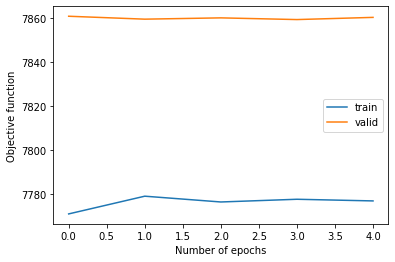

In [ ]:
from matplotlib import pyplot as plt
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, valid_losses, label="valid")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Objective function")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(tqdm(valid_loader)):
        if (i == 0):
            testx = data
            data = data.to(device)
            decode_temp, mu_temp, logvar_temp = model(data)
            test_mu = mu_temp.cpu()
            test_logvar = logvar_temp.cpu()
            test_decode = decode_temp.cpu()
        else:
            testx = torch.cat((testx, data), 0)
            data = data.to(device)
            decode_temp, mu_temp, logvar_temp = model(data)
            test_mu = torch.cat((test_mu, mu_temp.cpu()), 0)
            test_logvar = torch.cat((test_logvar, logvar_temp.cpu()), 0)
            test_decode = torch.cat((test_decode, decode_temp.cpu()), 0)


100%|██████████| 50/50 [00:58<00:00,  1.16s/it]


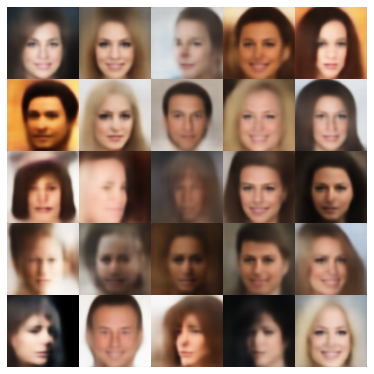

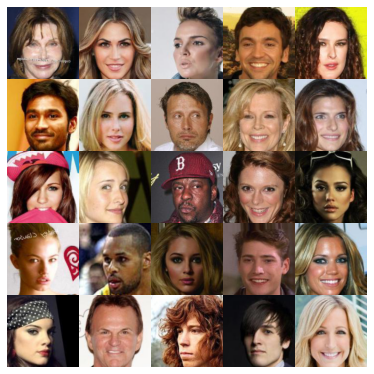

In [ ]:
from matplotlib import pyplot as plt
from numpy import transpose

show_img = True
if show_img:
    idx = np.linspace(0, 24, 25)
    # idx = np.random.randint(0, testx.shape[0]-1, 10)
    X0 = testx[idx,:,:,:]
    recon_X0 = test_decode[idx,:,:,:]
    fig, ax = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            ax[i,j].imshow(recon_X0[i*5+j].numpy().transpose((1, 2, 0)))
            ax[i,j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    # plt.savefig("IBVAE_CelebA.png")
    plt.show()
    
    fig0, ax0 = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            ax0[i,j].imshow(X0[i*5+j].numpy().transpose((1, 2, 0)))
            ax0[i,j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    # plt.savefig("CelebA.png")
    plt.show()


In [ ]:
'''
from torch import nn
from torch import optim
class IBAE(nn.Module):
    def __init__(self):
        super(IBAE, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1) # b, 32, 32, 32
        self.norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # b, 64, 16, 16
        self.norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # b, 128, 8, 8
        self.norm3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) # b, 256, 4, 4
        self.norm4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1) # b, 512, 2, 2
        self.norm5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()
        self.line1 = nn.Linear(512*2*2, 100)
    
        self.line2 = nn.Linear(100, 512*2*2)
        self.conv6 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0) # b, 256, 4, 4 
        self.norm6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.conv7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0) # b, 128, 8, 8
        self.norm7 = nn.BatchNorm2d(128)
        self.relu7 = nn.ReLU()
        self.conv8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0) # b, 64, 16, 16
        self.norm8 = nn.BatchNorm2d(64)
        self.relu8 = nn.ReLU()
        self.conv9 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0) # b, 32, 32, 32
        self.norm9 = nn.BatchNorm2d(32)
        self.relu9 = nn.ReLU()
        self.conv10 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2, padding=0) # b, 3, 64, 64
        self.relu10 = nn.Sigmoid()

    def encoder(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.norm5(x)
        x = self.relu5(x)
        x = x.view(-1, 512*2*2)
        x = self.line1(x)
        return x

    def decoder(self,x):
        x = self.line2(x)
        x = x.view(-1, 512, 2, 2)
        x = self.conv6(x)
        x = self.norm6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = self.norm7(x)
        x = self.relu7(x)
        x = self.conv8(x)
        x = self.norm8(x)
        x = self.relu8(x)
        x = self.conv9(x)
        x = self.norm9(x)
        x = self.relu9(x)
        x = self.conv10(x)
        x = self.relu10(x)
        return x

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
'''